# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow 
from   tensorflow.keras.models                  import *
from   tensorflow.keras.layers                  import *
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *
from   tensorflow.keras.callbacks               import EarlyStopping
from   tensorflow.keras.callbacks               import ModelCheckpoint
from   tensorflow.keras.callbacks               import ReduceLROnPlateau


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

## CUDA

In [3]:
try:
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tensorflow.config.experimental.set_memory_growth(gpu, True)

            logical_gpus = tensorflow.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        except RuntimeError as e:

            # Memory growth must be set before GPUs have been initialized
            print(e)
except:
    print('[INFO] Not GPU found')

## Neural networks parameters

In [4]:
Lag        =   12
Horizon    =    2
#
epochs     =  200
batch_size =  128

# Data handling

## Import data


In [5]:
# # Parameters
# #
# filename   = '../metadata/7-kanal-1.csv'

# Transformation  = True
# Scaling         = 'Standard'



# # Start timer
# #
# start = time.time()

# # Load data
# #
# df = pd.read_csv( filename )

# print('[INFO] Data imported')
# print('[INFO] Time: %.2f seconds' % (time.time() - start))

# df.head(3)

In [6]:
# Parameters
#
filename   = '../Data/D-6-It.csv'

Transformation  = True
Scaling         = 'Standard'




# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv(filename, 
                 sep = ',')


# Rename columns
#
df = df.rename(columns = {'created_at' : 'Date',
                          'field1' : 'Temperature',
                          'field2' : 'Humidity',
                          'field3' : 'PM2.5',
                          'field4' : 'PM10',
                          'field5' : 'NO2',
                          'field6' : 'CO',
                          'field7' : 'NH4',})



# End timer
#
print('[INFO] Time: %.2f' % (time.time() - start))

df.head( 3 )

[INFO] Time: 0.61


,Date,entry_id,Temperature,Humidity,PM2.5,PM10,NO2,CO,NH4,field8,latitude,longitude,elevation,status
0,2022-07-21T13:46:57+00:00,1,26.89,48.0,180.3,938.29999,161.0,180.0,167.0,4.0,NaN,NaN,NaN,NaN
1,2022-07-21T13:46:58+00:00,2,26.89,48.0,178.0,925.70001,162.0,180.0,167.0,3.0,NaN,NaN,NaN,NaN
2,2022-07-21T13:47:00+00:00,3,26.89,48.0,175.0,922.29999,160.0,180.0,167.0,4.0,NaN,NaN,NaN,NaN


## Preprocess data

### Set index

In [7]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('10min').mean() 

# The last feature is the target variable
df = pd.DataFrame( df[ ['NO2', 'CO'] ] )

df.head(3)

,NO2,CO
Date,,
2022-07-21 13:40:00,155.666667,177.555556
2022-07-21 13:50:00,134.845890,165.821918
2022-07-21 14:00:00,116.583618,157.201365


In [8]:
# Set target series/Series which will be forecasted
# 
targetSeries = df.columns[-1]

# Set all other utilized features
Features = df.columns[:-1]

### Split Training/Testing

In [9]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ]
df_test  = df[ idx: ]

### Visualization

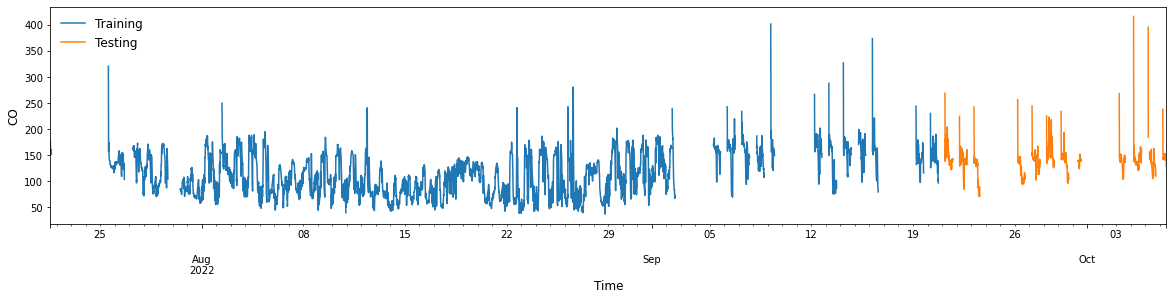

In [10]:
plt.figure( figsize = (20, 4) );
#
df_train[ targetSeries ].plot()
df_test[ targetSeries ].plot()
#
plt.legend(['Training', 'Testing'], fontsize = 12, frameon = False);
plt.ylabel( targetSeries, size = 12);
plt.xlabel( 'Time', size = 12);

### Fixing Lag

In [11]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [12]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(abs( -df.min().min() ) + 1.0, 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
    

    # Transformation parameter
    #
    d = {'parameter': VALUE}

    import json
    with open('model/Transformation.json', 'w') as fp:
        json.dump(d, fp)
    print('[INFO] Parameters saved')

else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied
[INFO] Parameters saved


In [13]:
import pickle

if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    # Set scaler
    #
    scaler = MinMaxScaler()
    
    df_train[ Features ] = scaler.fit_transform( df_train[ Features ].to_numpy().reshape(-1,1) )
    df_test[ Features ]  = scaler.transform( df_test[ Features ].to_numpy().reshape(-1,1) )

    # Save Encoder
    #
    filename = 'model/Feature_scaler.pkl'
    pickle.dump(scaler, open(filename, 'wb'))
    print('[INFO] Feature scaler saved in ', filename)


    # Scaling of Target Series
    #
    scaler = MinMaxScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
    # Save Encoder
    #
    filename = 'model/Target_scaler.pkl'
    pickle.dump(scaler, open(filename, 'wb'))
    print('[INFO] Target scaler saved in ', filename)

    
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    # Set scaler
    #
    scaler = RobustScaler()
    
    df_train[ Features ] = scaler.fit_transform( df_train[ Features ].to_numpy().reshape(-1,1) )
    df_test[ Features ]  = scaler.transform( df_test[ Features ].to_numpy().reshape(-1,1) )

    # Save Encoder
    #
    filename = 'model/Feature_scaler.pkl'
    pickle.dump(scaler, open(filename, 'wb'))
    print('[INFO] Feature scaler saved in ', filename)


    # Scaling of Target Series
    #
    scaler = RobustScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
    # Save Encoder
    #
    filename = 'model/Target_scaler.pkl'
    pickle.dump(scaler, open(filename, 'wb'))
    print('[INFO] Target scaler saved in ', filename)
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    # Set scaler
    #
    scaler = StandardScaler()
    
    df_train[ Features ] = scaler.fit_transform( df_train[ Features ].to_numpy().reshape(-1,1) )
    df_test[ Features ]  = scaler.transform( df_test[ Features ].to_numpy().reshape(-1,1) )

    # Save Encoder
    #
    filename = 'model/Feature_scaler.pkl'
    pickle.dump(scaler, open(filename, 'wb'))
    print('[INFO] Feature scaler saved in ', filename)


    # Scaling of Target Series
    #
    scaler = StandardScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
    # Save Encoder
    #
    filename = 'model/Target_scaler.pkl'
    pickle.dump(scaler, open(filename, 'wb'))
    print('[INFO] Target scaler saved in ', filename)       
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   

[INFO] Scaling: Standard
[INFO] Feature scaler saved in  model/Feature_scaler.pkl
[INFO] Target scaler saved in  model/Target_scaler.pkl


## Create Training/Testing data

In [14]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY = [], []
    
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):

        # Check for NaN values
        if (df[i:i + Lag + Horizon].dropna().shape[0] != df[i:i + Lag + Horizon].shape[0]): continue
                
        dataX.append( df.to_numpy()[i:(i+Lag)] )        
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        
        
    return ( np.array(dataX), np.array(dataY) )


In [15]:
trainX, trainY = create_dataset(df           = df_train, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = 1,)
                               

testX,  testY  = create_dataset(df           = df_test, 
                                Lag          = Lag, 
                                Horizon      = Horizon, 
                                targetSeries = targetSeries,
                                overlap      = Horizon,)


print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|██████████| 1107/1107 [00:00<00:00, 1463.52it/s]

Training instances:     5941
Testing instances:       318


# Forecasting model

In [16]:
import random, os
seed = 42
    
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

## Setup model

In [17]:
from utils.Attention import *
# https://github.com/philipperemy/keras-attention-mechanism


model_input = Input(shape=( trainX.shape[1], trainX.shape[2]) )   


x = Conv1D(filters=32, kernel_size=2, padding='same', activation='relu' )(model_input)
x = MaxPool1D(2)(x)

x = Attention(100)(x)
#
x = Dense(32)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
  
x = Dense(Horizon, activation='linear')(x)


model = Model(model_input, x)

2022-10-10 20:55:18.958071: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training parameters

In [18]:
# Define metrics
#
metrics = [
            MeanAbsoluteError(name = "MAE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]

model.compile(loss = 'mse', optimizer = Adam(learning_rate = 5.e-4), metrics = metrics)
# 

In [19]:
# Checkpoint
#
checkpoint = ModelCheckpoint("model/CO_model.hdf5", 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 20)

# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                   factor      = 0.5,
                                   patience    = 10)

## Training process

In [20]:
# Start clock
#
start = time.time()


score = model.fit(trainX, trainY,                   
                  epochs           = epochs, 
                  batch_size       = batch_size, 
                  callbacks        = [checkpoint, earlystopping, lrs_scheduler],
                  shuffle          = True,
                  verbose          = 1, 
                  validation_split = 0.2)


# Terminate clock
#
stop = time.time()
print('[INFO] Time %.2f' % (stop - start))

Epoch 1/200
38/38 [==============================] - 1s 7ms/step - loss: 1.1366 - MAE: 0.7729 - RMSE: 1.0661 - val_loss: 0.4647 - val_MAE: 0.5985 - val_RMSE: 0.6817 - lr: 5.0000e-04
Epoch 2/200
38/38 [==============================] - 0s 3ms/step - loss: 0.5821 - MAE: 0.5769 - RMSE: 0.7629 - val_loss: 0.4359 - val_MAE: 0.5794 - val_RMSE: 0.6602 - lr: 5.0000e-04
Epoch 3/200
38/38 [==============================] - 0s 3ms/step - loss: 0.5803 - MAE: 0.5714 - RMSE: 0.7618 - val_loss: 0.3390 - val_MAE: 0.5048 - val_RMSE: 0.5823 - lr: 5.0000e-04
Epoch 4/200
38/38 [==============================] - 0s 3ms/step - loss: 0.5436 - MAE: 0.5539 - RMSE: 0.7373 - val_loss: 0.3167 - val_MAE: 0.4861 - val_RMSE: 0.5628 - lr: 5.0000e-04
Epoch 5/200
38/38 [==============================] - 0s 3ms/step - loss: 0.4995 - MAE: 0.5299 - RMSE: 0.7068 - val_loss: 0.2297 - val_MAE: 0.3969 - val_RMSE: 0.4793 - lr: 5.0000e-04
Epoch 6/200
38/38 [==============================] - 0s 3ms/step - loss: 0.4825 - MAE: 0.5

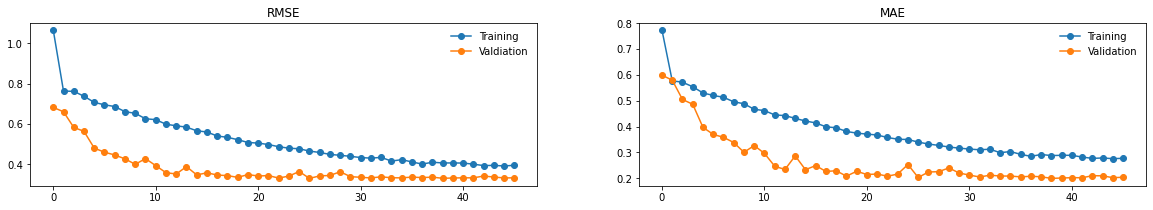

In [21]:
# Create figure
#
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 3) )

# Plot RMSE
#
ax[0].plot( score.history['RMSE'], marker = 'o');
ax[0].plot( score.history['val_RMSE'], marker = 'o');
ax[0].legend(['Training', 'Valdiation'], frameon = False);
ax[0].set_title('RMSE');

# Plot RMSE
#
ax[1].plot( score.history['MAE'], marker = 'o');
ax[1].plot( score.history['val_MAE'], marker = 'o');
ax[1].legend(['Training', 'Validation'], frameon = False);
ax[1].set_title('MAE');

## Load optimized model

In [22]:
# Load the best model
#
model.load_weights('model/CO_model.hdf5')

print('[INFO] Model loaded')

[INFO] Model loaded


## Evaluation

### Get predictions

In [23]:
# Get predictions
#
pred = model.predict( testX )

### Apply inverse scaling/transformation

In [24]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred  = np.exp( pred )  - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [25]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]


    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]

    # Present results
    #
#     print('Horizon: ', i+1)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' % (i+1, MAE, SMAPE, R2) )

[INFO] Feature:  CO
------------------------------------------------
Horizon:  1 MAE  5.70 SMAPE:  4.19 R2: 0.86
Horizon:  2 MAE  7.71 SMAPE:  5.66 R2: 0.71


### Reliability evaluation

[INFO] Feature:  CO
------------------------------------------------


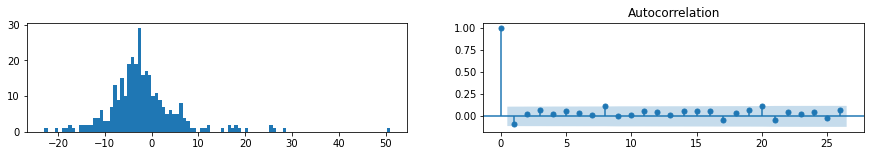

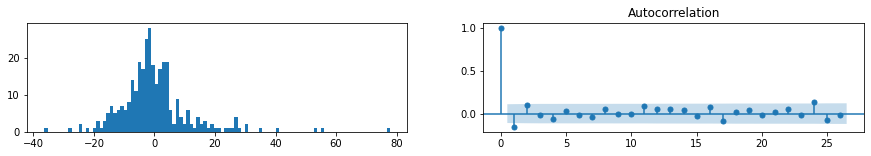

In [26]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices[targetSeries] = testY[:,i]
    Prices['Prediction'] = pred[:,i]
            
            

            
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf
    
    res = (Prices[targetSeries] - Prices['Prediction']).to_numpy()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    ax[0].hist( res, bins = 100 )    
    plot_acf( res, ax=ax[1] )       

## Visualization

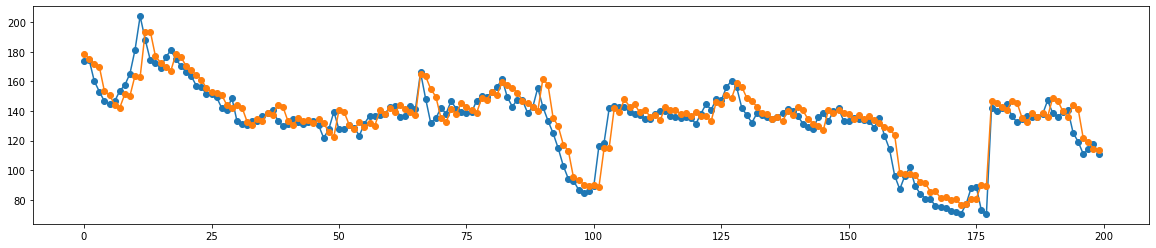

In [27]:
Prices = pd.DataFrame( [] )

Prices[targetSeries] = testY.flatten()
Prices['Prediction'] = pred.flatten()


# Plot results
#
plt.figure( figsize = (20, 4) );
#
Prices[ targetSeries ][:200].plot(color = 'tab:blue', marker = 'o')
Prices[ 'Prediction' ][:200].plot(color = 'tab:orange', marker = 'o')
plt.show();
